# KNN Regression

## Name: <span style="color:blue"> *Azaan Patil* </span>

In [84]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  K-Nearest Neighbors(KNN)

#### Data Loading


In [85]:
import pandas as pd

df = pd.read_csv("../Data/House_listings_dataset.csv")

df = df.rename(columns={
    'Bedroom': 'bed',
    'Bathroom': 'bath',
    'ConvertedLot': 'acre_lot',
    'Area': 'house_size',
    'State': 'state',
    'Price': 'price'
})

df['property_type'] = df['City']

df = df.dropna(subset=['bed', 'bath', 'acre_lot', 'house_size', 'state', 'price'])

class DataBundle:
    def __init__(self, data, target, feature_names):
        self.data = data
        self.target = target
        self.feature_names = feature_names

numeric_features = ['bed', 'bath', 'acre_lot', 'house_size']
categorical_features = ['state', 'property_type']
target_name = 'price'

features = numeric_features + categorical_features
X_df = df[features].copy()
y_series = df[target_name].copy()

house_data = DataBundle(
    data=X_df,
    target=y_series,
    feature_names=features
)

Accessing Individual Data:

In [86]:
house_data.__dict__.keys()

dict_keys(['data', 'target', 'feature_names'])

In [87]:
house_data.data

,bed,bath,acre_lot,house_size,state,property_type
0,4.0,2.0,0.38050,1614.0,AL,Saraland
1,3.0,2.0,0.67034,1474.0,AL,Southside
2,3.0,2.0,3.20000,1800.0,AL,Robertsdale
4,3.0,3.0,0.26000,2224.0,AL,Chelsea
6,3.0,2.0,0.20000,1564.0,AL,Montgomery
...,...,...,...,...,...,...
24516,2.0,1.0,20.00000,1112.0,WY,Burns
24517,2.0,3.0,0.03000,1232.0,WY,Cody
24518,2.0,2.0,1.42000,2016.0,WY,Dubois
24519,3.0,2.0,6.23000,2930.0,WY,Cheyenne


In [88]:
house_data.data.shape

(22012, 6)

In [89]:
house_data.target

0        239900.0
1             1.0
2        259900.0
4        335000.0
6        151000.0
           ...   
24516    375000.0
24517    297900.0
24518    530000.0
24519    575900.0
24520    329900.0
Name: price, Length: 22012, dtype: float64

In [90]:
house_data.feature_names

['bed', 'bath', 'acre_lot', 'house_size', 'state', 'property_type']

## Visualizations

Pairplot

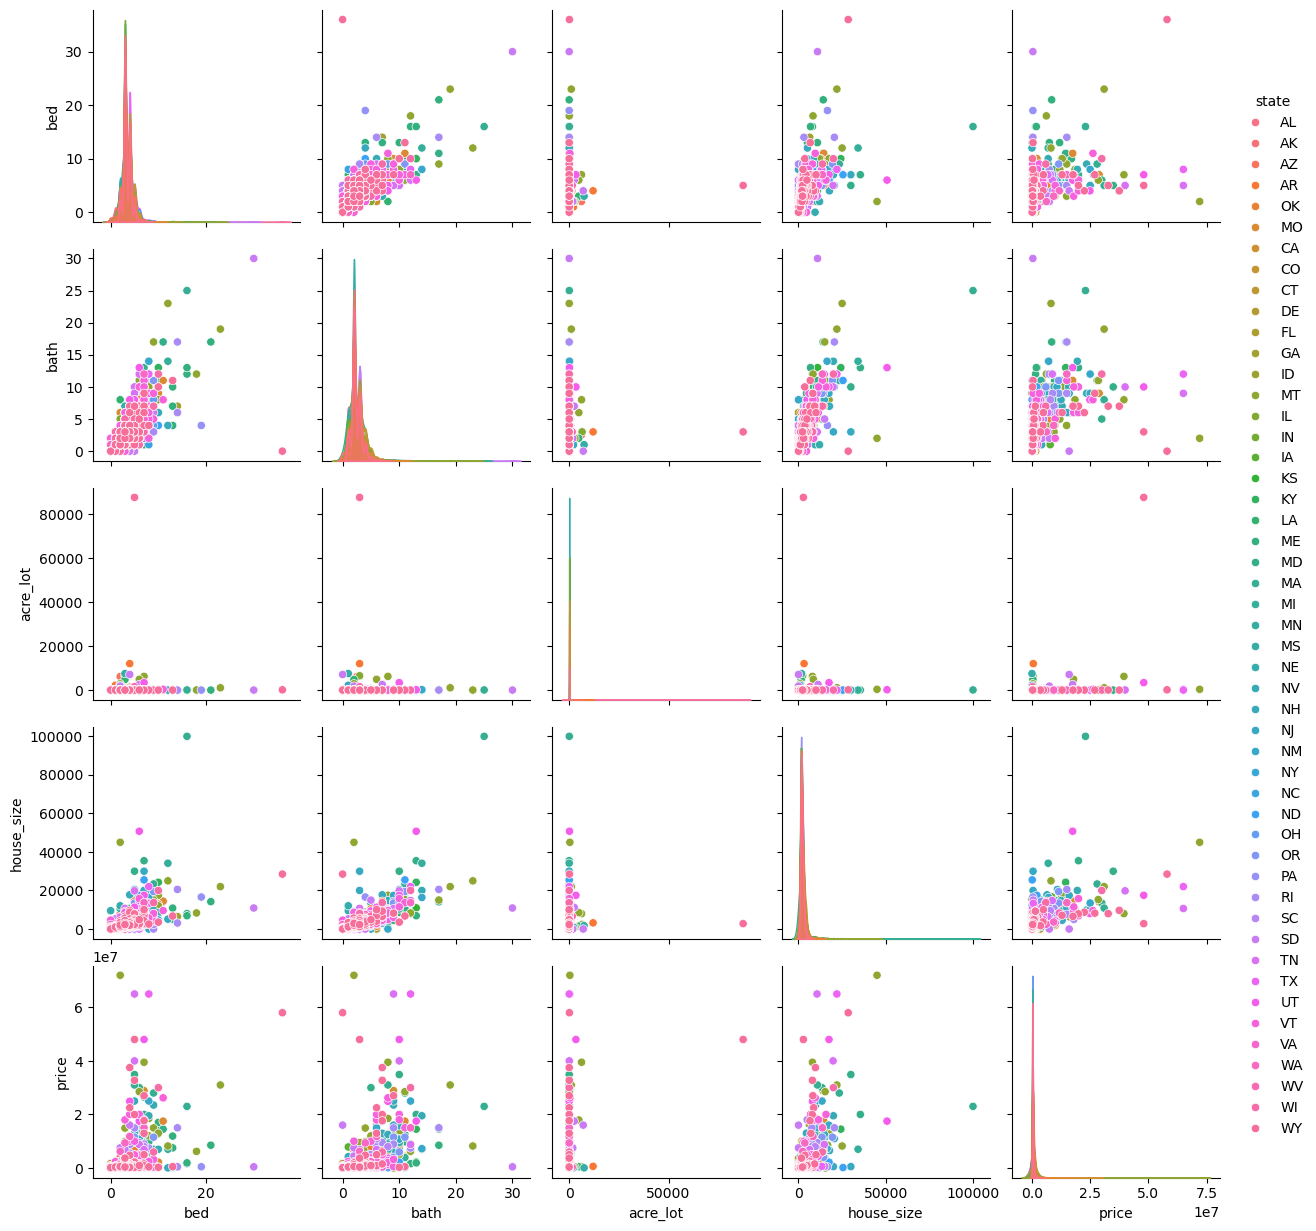

In [91]:
# TODO 4.1
import seaborn as sns
import pandas as pd

# TODO 4.2
house_df = pd.concat([house_data.data, house_data.target], axis=1)
house_subset_df = house_df[
    ['bed', 'bath', 'acre_lot', 'house_size', 'state', 'price']
]

# TODO 4.3
sns.pairplot(house_subset_df, hue='state')

## Data Preprocessing

Train and Test Splits

In [92]:
def train_test_split(
    X: np.ndarray, 
    y: np.ndarray,
    train_size: float, 
    random_state: int
) -> tuple:
    """ Randomizes and then splits the data into train and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 

            train_size: A number between 0.0 and 1.0 and represent the 
                proportion of the dataset to include in the train split.

            random_state: The seed which controls the shuffling applied 
                to the data before being split.
                
        Return:
            A tuple of NumPy arrays where the 1st element corresponds to
            the training data, the 2nd element the testing data, the 3rd
            the training labels, the 4th testing labels.
    """

    rng = np.random.RandomState(random_state)
    random_idx = rng.permutation(len(X))
    X = X[random_idx]
    y = y[random_idx]
    split_idx = int(len(X) * train_size)

    X_trn = X[:split_idx]
    X_tst = X[split_idx:]
    y_trn = y[:split_idx]
    y_tst = y[split_idx:]

    return X_trn, X_tst, y_trn, y_tst

In [93]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['bed', 'bath', 'acre_lot', 'house_size']
categorical_features = ['state', 'property_type']
features = numeric_features + categorical_features

X_raw = house_data.data[features].copy()
y = house_data.target.copy()

X_encoded = pd.get_dummies(X_raw, columns=categorical_features, drop_first=True)

scaler = StandardScaler()
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])

print(f"Features after preprocessing:")
print(f"X shape: {X_encoded.shape}")
print(f"y shape: {y.shape}")
display(X_encoded.head())

Features after preprocessing:
X shape: (22012, 5496)
y shape: (22012,)


,bed,bath,acre_lot,house_size,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,...,property_type_Zebulon,property_type_Zeeland,property_type_Zephyr Cove,property_type_Zephyrhills,property_type_Zillah,property_type_Zimmerman,property_type_Zion,property_type_Zionsville,property_type_Zoe,property_type_Zwolle
0,0.529804,-0.361245,-0.015658,-0.323294,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.371715,-0.361245,-0.015181,-0.409911,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.371715,-0.361245,-0.011017,-0.208218,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.371715,0.477840,-0.015856,0.054107,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,-0.371715,-0.361245,-0.015955,-0.354229,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Coding KNN 

#### KNN Code

KNN Regression (k=3)
RMSE: 1125009.510
MAE:  223825.158
R^2:  0.339


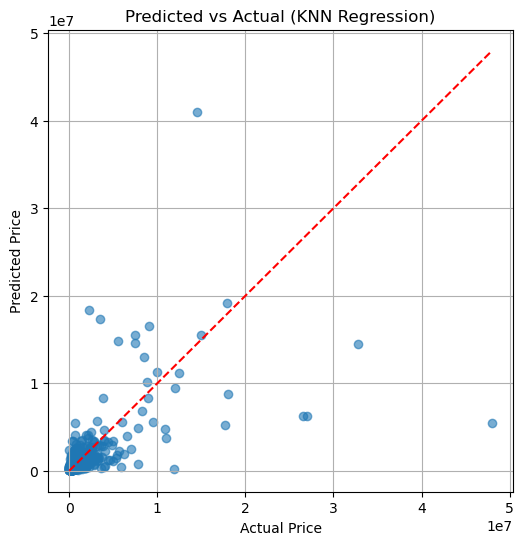

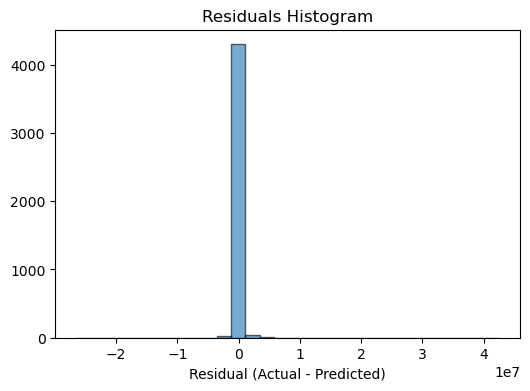

In [94]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

try:
    X_trn
except NameError:
    raise RuntimeError("Run the preprocessing cells above first so `X_trn, X_tst, y_trn, y_tst` are defined.")

k = 3
reg = KNeighborsRegressor(n_neighbors=k)
reg.fit(X_trn, y_trn)

y_pred = reg.predict(X_tst)

mse = mean_squared_error(y_tst, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_tst, y_pred)
r2 = r2_score(y_tst, y_pred)

print(f"KNN Regression (k={k})")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R^2:  {r2:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_tst, y_pred, alpha=0.6)
plt.plot([y_tst.min(), y_tst.max()], [y_tst.min(), y_tst.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual (KNN Regression)')
plt.grid(True)
plt.show()

residuals = y_tst - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.6)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residuals Histogram')
plt.show()


In [95]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

reg_example = KNeighborsRegressor(n_neighbors=3)
reg_example.fit(X_trn, y_trn)
example_pred = reg_example.predict(X_tst[:10])
print('Example predictions (first 10):', example_pred)

full_pred = reg_example.predict(X_tst)
rmse_example = np.sqrt(mean_squared_error(y_tst, full_pred))
print(f'Example model RMSE (k=3): {rmse_example:.3f}')

Example predictions (first 10): [ 199933.33333333  358000.         1414666.66666667  339300.
  290766.66666667  401600.          210930.          808000.
  583266.66666667  839600.        ]
Example model RMSE (k=3): 1125009.510
Example model RMSE (k=3): 1125009.510


#### KNN Hyper-parameters

k=1: RMSE=1251171.593, MAE=257871.295, R2=0.182
k=3: RMSE=1125009.510, MAE=223825.158, R2=0.339
k=3: RMSE=1125009.510, MAE=223825.158, R2=0.339
k=5: RMSE=1030062.908, MAE=223183.748, R2=0.446
k=5: RMSE=1030062.908, MAE=223183.748, R2=0.446
k=10: RMSE=994557.892, MAE=215091.470, R2=0.483
k=10: RMSE=994557.892, MAE=215091.470, R2=0.483
k=20: RMSE=1018849.404, MAE=215284.497, R2=0.458
k=20: RMSE=1018849.404, MAE=215284.497, R2=0.458
k=50: RMSE=1036637.328, MAE=214268.977, R2=0.438
k=50: RMSE=1036637.328, MAE=214268.977, R2=0.438


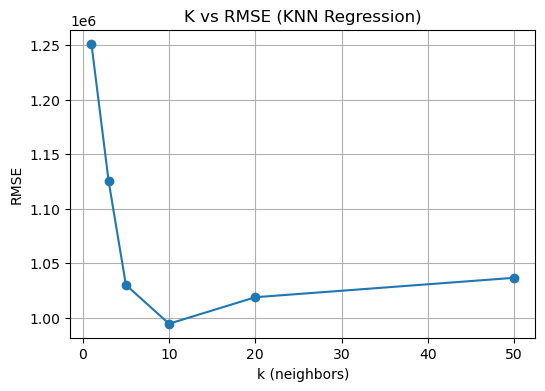

,k,RMSE,MAE,R2
0,1,1.251172e+06,257871.294572,0.181922
1,3,1.125010e+06,223825.157620,0.338586
2,5,1.030063e+06,223183.748263,0.445517
3,10,9.945579e+05,215091.469634,0.483083
4,20,1.018849e+06,215284.497365,0.457524
5,50,1.036637e+06,214268.976670,0.438416


In [96]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

k_values = [1, 3, 5, 10, 20, 50]
results = []

for k in k_values:
    reg = KNeighborsRegressor(n_neighbors=k)
    reg.fit(X_trn, y_trn)
    y_pred_k = reg.predict(X_tst)
    rmse_k = np.sqrt(mean_squared_error(y_tst, y_pred_k))
    mae_k = mean_absolute_error(y_tst, y_pred_k)
    r2_k = r2_score(y_tst, y_pred_k)
    results.append((k, rmse_k, mae_k, r2_k))
    print(f"k={k}: RMSE={rmse_k:.3f}, MAE={mae_k:.3f}, R2={r2_k:.3f}")

ks = [r[0] for r in results]
rmses = [r[1] for r in results]
plt.figure(figsize=(6,4))
plt.plot(ks, rmses, marker='o')
plt.xlabel('k (neighbors)')
plt.ylabel('RMSE')
plt.title('K vs RMSE (KNN Regression)')
plt.grid(True)
plt.show()

import pandas as pd
results_df = pd.DataFrame(results, columns=['k','RMSE','MAE','R2'])
display(results_df)
